# Pronóstico de Ventas con Redes Neuronales

## 1. Predicción de Series Temporales con Redes Neuronales

### 1.1. Usaremos Keras y Tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.preprocessing import MinMaxScaler
import requests
from io import StringIO

### 1.2. Cargamos nuestro dataset

In [3]:
url = 'https://raw.githubusercontent.com/jbagnato/machine-learning/master/time_series.csv'

response = requests.get(url)
csv_content = StringIO(response.text)

df = pd.read_csv(
    csv_content,
    parse_dates=[0],
    header=None,
    index_col=0,
    names=['fecha', 'unidades']
)
df.head()

,unidades
fecha,
2017-01-02,236
2017-01-03,237
2017-01-04,290
2017-01-05,221
2017-01-07,128


In [4]:
df.describe()

,unidades
count,604.000000
mean,215.935430
std,75.050304
min,51.000000
25%,171.000000
50%,214.000000
75%,261.250000
max,591.000000


In [5]:
print(df.index.min())
print(df.index.max())

2017-01-02 00:00:00
2018-11-30 00:00:00


In [6]:
print(len(df.loc['2017']))
print(len(df.loc['2018']))

315
289


In [7]:
meses = df.resample('M').mean()
meses

C:\Users\pepel\AppData\Local\Temp\ipykernel_12544\3818076977.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  meses = df.resample('M').mean()


,unidades
fecha,
2017-01-31,203.923077
2017-02-28,184.666667
2017-03-31,182.964286
2017-04-30,198.960000
2017-05-31,201.185185
2017-06-30,209.518519
2017-07-31,278.923077
2017-08-31,316.000000
2017-09-30,222.925926


### 1.3. Visualizaciones

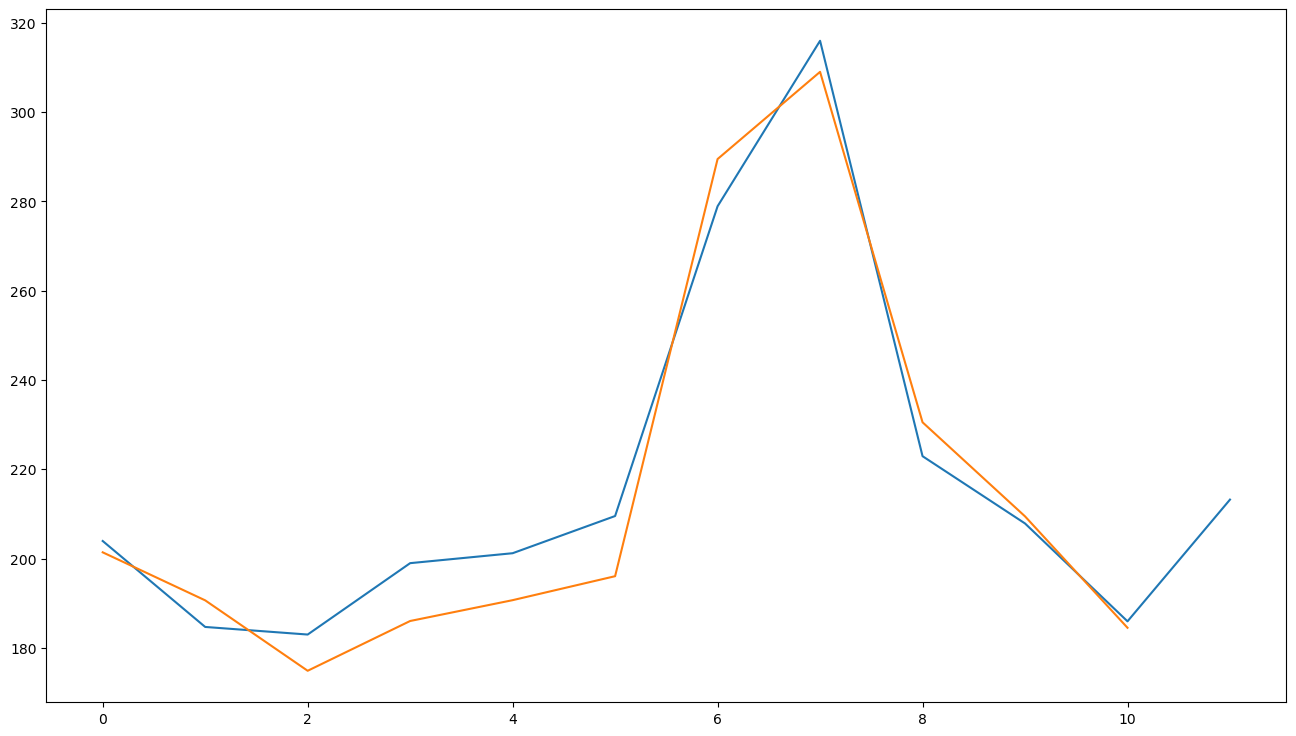

In [8]:
plt.plot(meses.loc['2017'].values)
plt.plot(meses.loc['2018'].values)

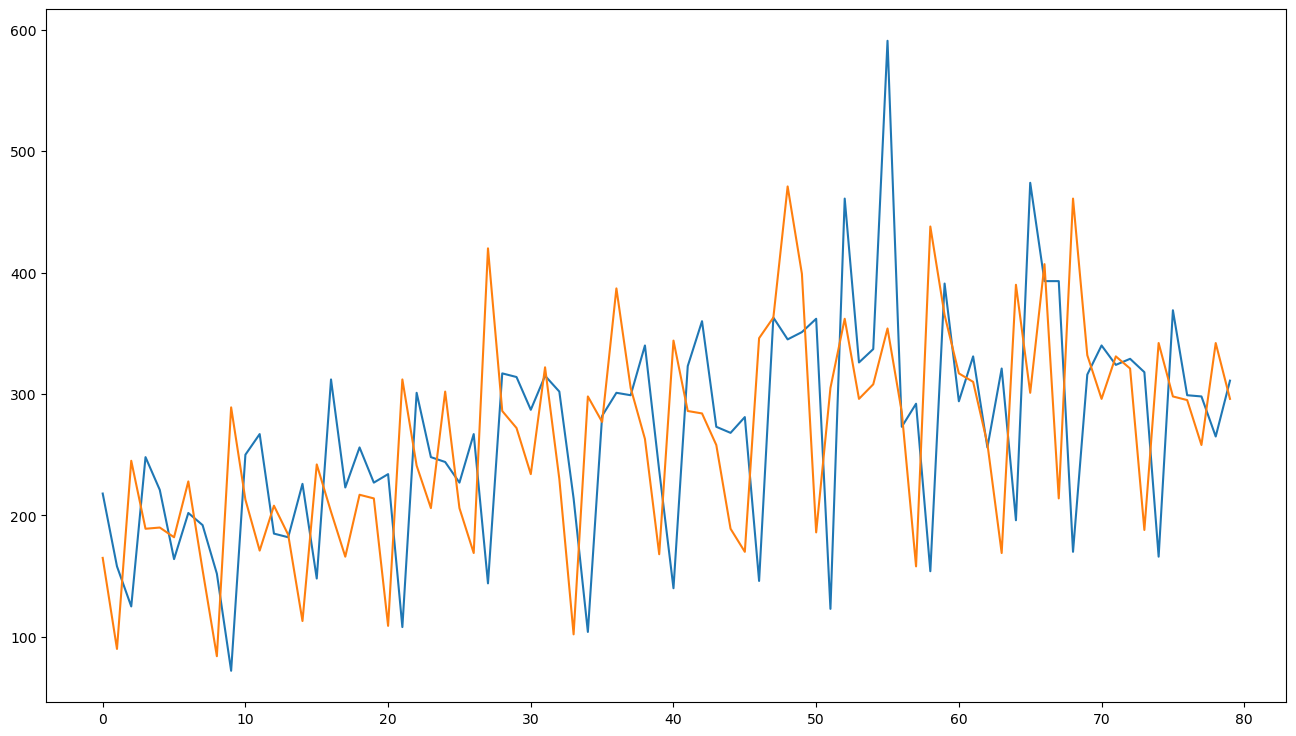

In [9]:
verano2017 = df['2017-06-01':'2017-09-01']
plt.plot(verano2017.values)
verano2018 = df['2018-06-01':'2018-09-01']
plt.plot(verano2018.values)

### 1.4. Preprocesado de datos

In [10]:
PASOS = 7

# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # Forecast sequence (t, t+1, ..., t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i==0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Load dataset
values = df.values
# Ensure all data is float
values = values.astype('float32')
# Normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values = values.reshape(-1, 1)  # Esto lo hacemos porque tenemos una sola dimensión
scaled = scaler.fit_transform(values)
# Frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-7),var1(t),var1(t-6),var1(t),var1(t-5),var1(t),var1(t-4),var1(t),var1(t-3),var1(t),var1(t-2),var1(t),var1(t-1),var1(t)
7,-0.314815,-0.433333,-0.311111,-0.433333,-0.114815,-0.433333,-0.370370,-0.433333,-0.714815,-0.433333,-0.103704,-0.433333,-0.225926,-0.433333
8,-0.311111,-0.607407,-0.114815,-0.607407,-0.370370,-0.607407,-0.714815,-0.607407,-0.103704,-0.607407,-0.225926,-0.607407,-0.433333,-0.607407
9,-0.114815,-0.522222,-0.370370,-0.522222,-0.714815,-0.522222,-0.103704,-0.522222,-0.225926,-0.522222,-0.433333,-0.522222,-0.607407,-0.522222
10,-0.370370,-0.644444,-0.714815,-0.644444,-0.103704,-0.644444,-0.225926,-0.644444,-0.433333,-0.644444,-0.607407,-0.644444,-0.522222,-0.644444
11,-0.714815,-0.344444,-0.103704,-0.344444,-0.225926,-0.344444,-0.433333,-0.344444,-0.607407,-0.344444,-0.522222,-0.344444,-0.644444,-0.344444


### 1.5. Dividimos en set de entrenamiento y test

In [11]:
# Split into train and test sets
values = reframed.values
n_train_days = 315+289 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# Split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# Reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(567, 1, 13) (567,) (30, 1, 13) (30,)


### 1.6. Creamos el modelo de Red Neuronal

In [12]:
def crear_modeloFF():
    model = Sequential()
    model.add(Dense(13, input_shape=(1, 13), activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error', optimizer='Adam', metrics=['mse'])
    model.summary()
    return model

###  1.7. Entrenamos nuestro modelo

In [13]:
EPOCHS = 40

model = crear_modeloFF()

history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val), batch_size=PASOS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 13)             182       
                                                                 
 flatten (Flatten)           (None, 13)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 14        
                                                                 
Total params: 196
Trainable params: 196
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
81/81 [==============================] - 1s 3ms/step - loss: 0.1786 - mse: 0.0613 - val_loss: 0.0901 - val_mse: 0.0145
Epoch 2/40
81/81 [==============================] - 0s 2ms/step - loss: 0.0782 - mse: 0.0106 - val_loss: 0.0567 - val_mse: 0.0058
Epoch 3/40
81/81 [==============================] - 0s 2ms/ste

### 1.8. Visualizamos resultados

1/1 [==============================] - 0s 71ms/step


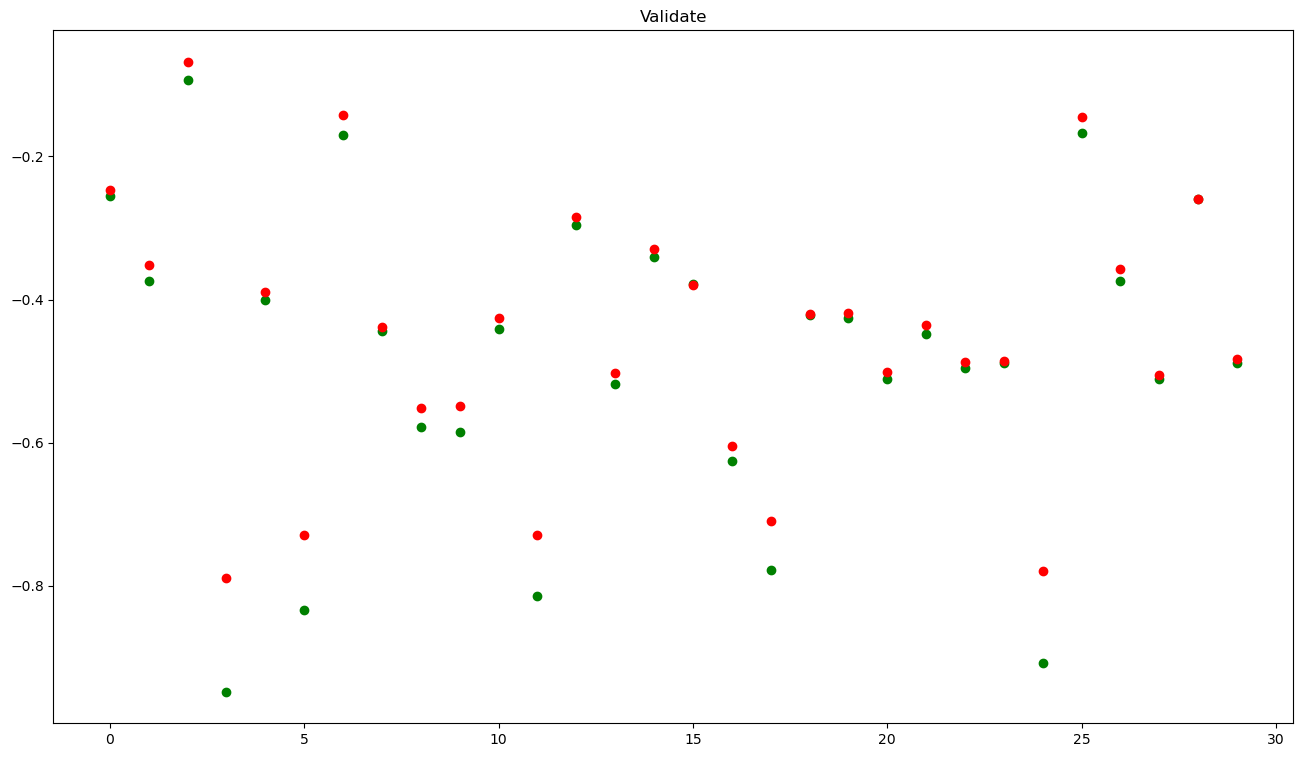

In [14]:
results = model.predict(x_val)
plt.scatter(range(len(y_val)), y_val, c='g')
plt.scatter(range(len(results)), results, c='r')
plt.title('Validate')
plt.show()

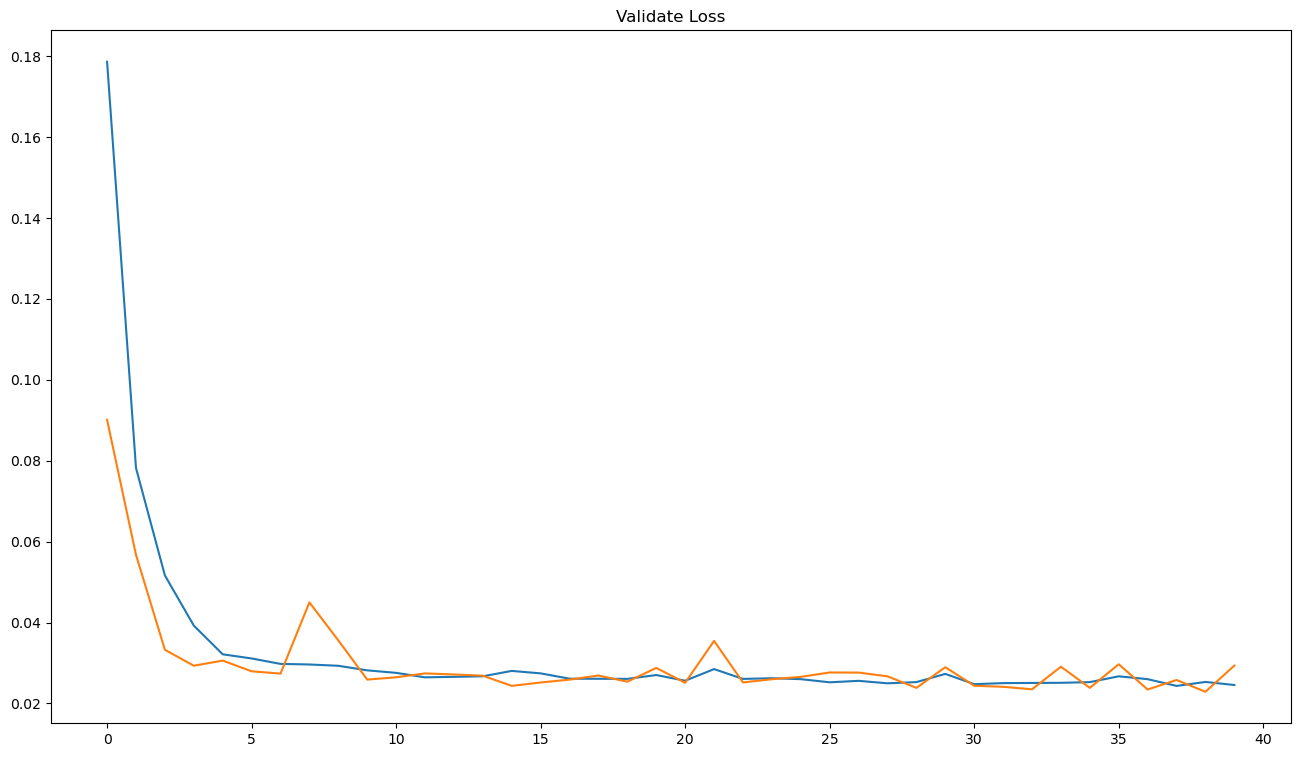

In [15]:
plt.plot(history.history['loss'])
plt.title('Loss')
plt.plot(history.history['val_loss'])
plt.title('Validate Loss')
plt.show()

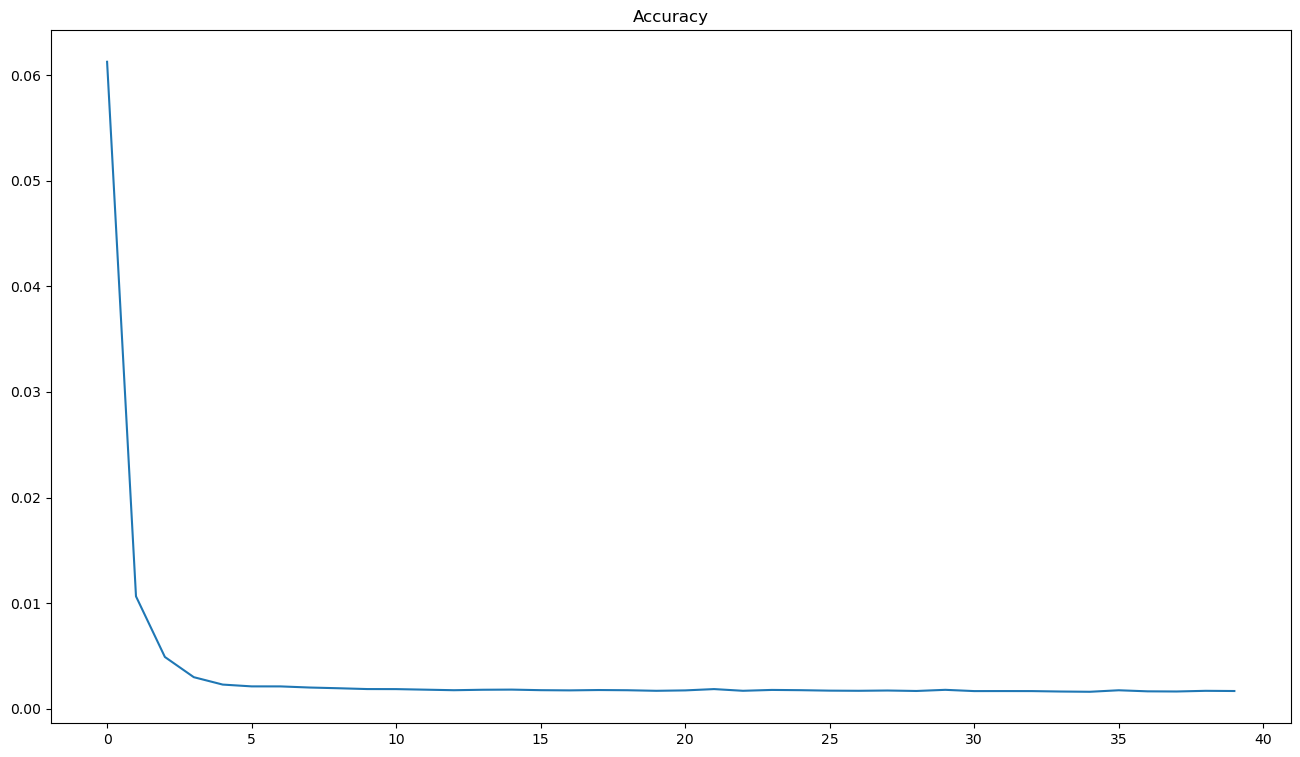

In [16]:
plt.title('Accuracy')
plt.plot(history.history['mse'])
plt.show()

In [17]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head()

,real,prediccion,diferencia
0,252.000000,254.276260,-2.276260
1,220.000000,226.076370,-6.076370
2,296.000000,302.708008,-6.708008
3,64.999992,107.855736,-42.855743
4,213.000000,216.008438,-3.008438


In [18]:
compara2.describe()

,real,prediccion,diferencia
count,30.000000,30.000000,30.000000
mean,191.633331,199.518570,-7.885252
std,57.580811,49.764191,10.718551
min,64.999992,107.855736,-42.855743
25%,169.000000,175.661060,-6.964252
50%,200.500000,203.035095,-3.750565
75%,220.000000,225.712154,-1.870487
max,296.000000,302.708008,0.370789


<Axes: >

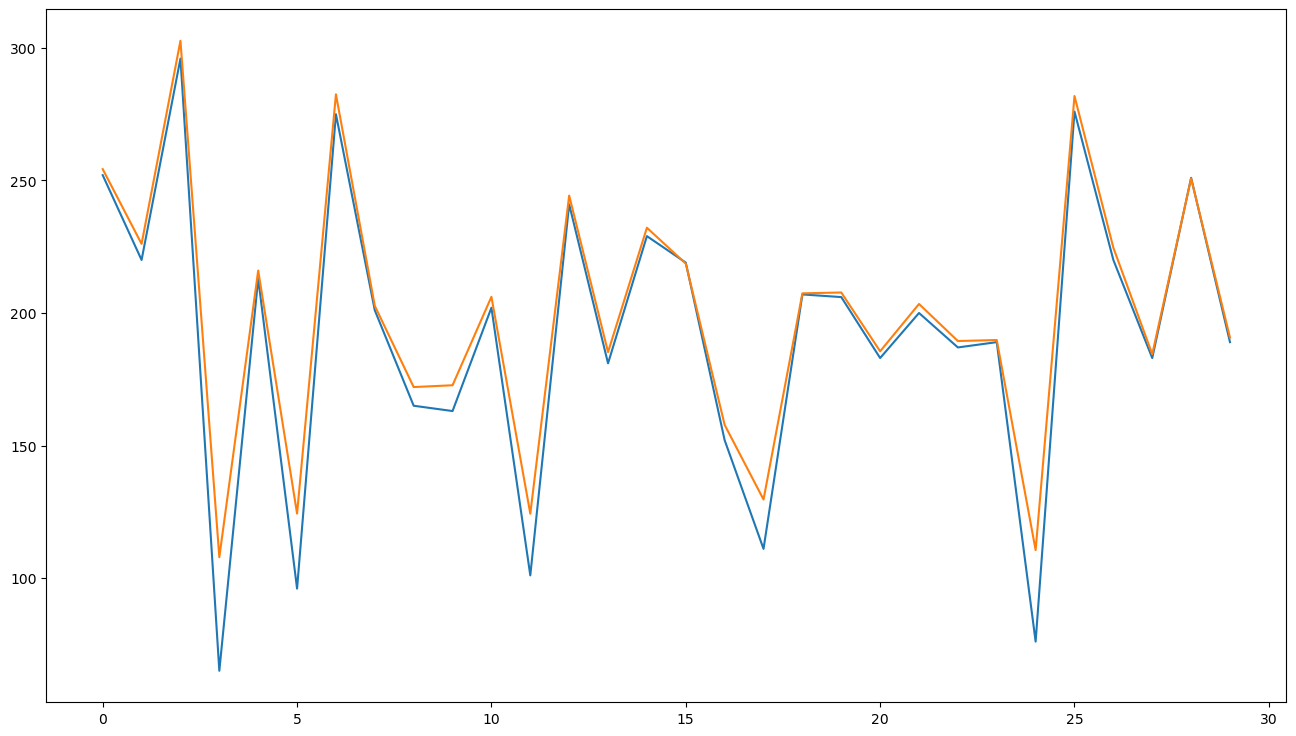

In [20]:
compara2['real'].plot()
compara2['prediccion'].plot()

### 1.9. Predicción

In [21]:
ultimosDias = df['2018-11-16':'2018-11-30']
ultimosDias

values = ultimosDias.values
values = values.astype('float32')
# Normalize features
values = values.reshape(-1, 1)  # Esto lo hacemos porque tenemos una sola dimensión
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-0.24,-0.65,0.31,0.30,0.07,0.24,0.11
8,-0.65,0.31,0.30,0.07,0.24,0.11,0.13
9,0.31,0.30,0.07,0.24,0.11,0.13,-1.00
10,0.30,0.07,0.24,0.11,0.13,-1.00,1.00
11,0.07,0.24,0.11,0.13,-1.00,1.00,0.44
12,0.24,0.11,0.13,-1.00,1.00,0.44,0.07
13,0.11,0.13,-1.00,1.00,0.44,0.07,0.75


In [22]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_test

array([[[ 0.11000001,  0.13      , -1.        ,  1.        ,
          0.44000006,  0.06999993,  0.75      ]]], dtype=float32)

In [23]:
def crear_modeloFF():
    model = Sequential()
    model.add(Dense(7, input_shape=(1, 7), activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error', optimizer='Adam', metrics=['mse'])
    model.summary()
    return model


def agregarNuevoValor(x_test, nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1] = nuevoValor
    return x_test

# Crear el modelo con la nueva configuración
model = crear_modeloFF()

results = []
for i in range(7):
    parcial = model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test = agregarNuevoValor(x_test, parcial[0])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1, 7)              56        
                                                                 
 flatten_1 (Flatten)         (None, 7)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 8         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 57ms/step
[[[ 0.11000001  0.13       -1.          1.          0.44000006
    0.06999993  0.75      ]]]
1/1 [==============================] - 0s 20ms/step
[[[ 0.13       -1.          1.          0.44000006  0.06999993
    0.75        0.7339137 ]]]
1/1 [===========================

C:\Users\pepel\AppData\Local\Temp\ipykernel_12544\88442686.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_test[0][0][x_test.shape[2]-1] = nuevoValor


[[[0.44000006 0.06999993 0.75       0.7339137  0.4336164  0.5224826
   0.27959913]]]
1/1 [==============================] - 0s 19ms/step
[[[0.06999993 0.75       0.7339137  0.4336164  0.5224826  0.27959913
   0.49862126]]]
1/1 [==============================] - 0s 19ms/step
[[[0.75       0.7339137  0.4336164  0.5224826  0.27959913 0.49862126
   0.41702974]]]


### 1.10. Re-Convertimos los resultados

In [24]:
adimen = [x for x in results]
inverted = scaler.inverse_transform(adimen)
inverted

array([[249.39137659],
       [219.36164393],
       [228.24826155],
       [203.95991662],
       [225.86212961],
       [217.70297775],
       [179.24504159]])

### 1.11. Visualizamos el pronóstico

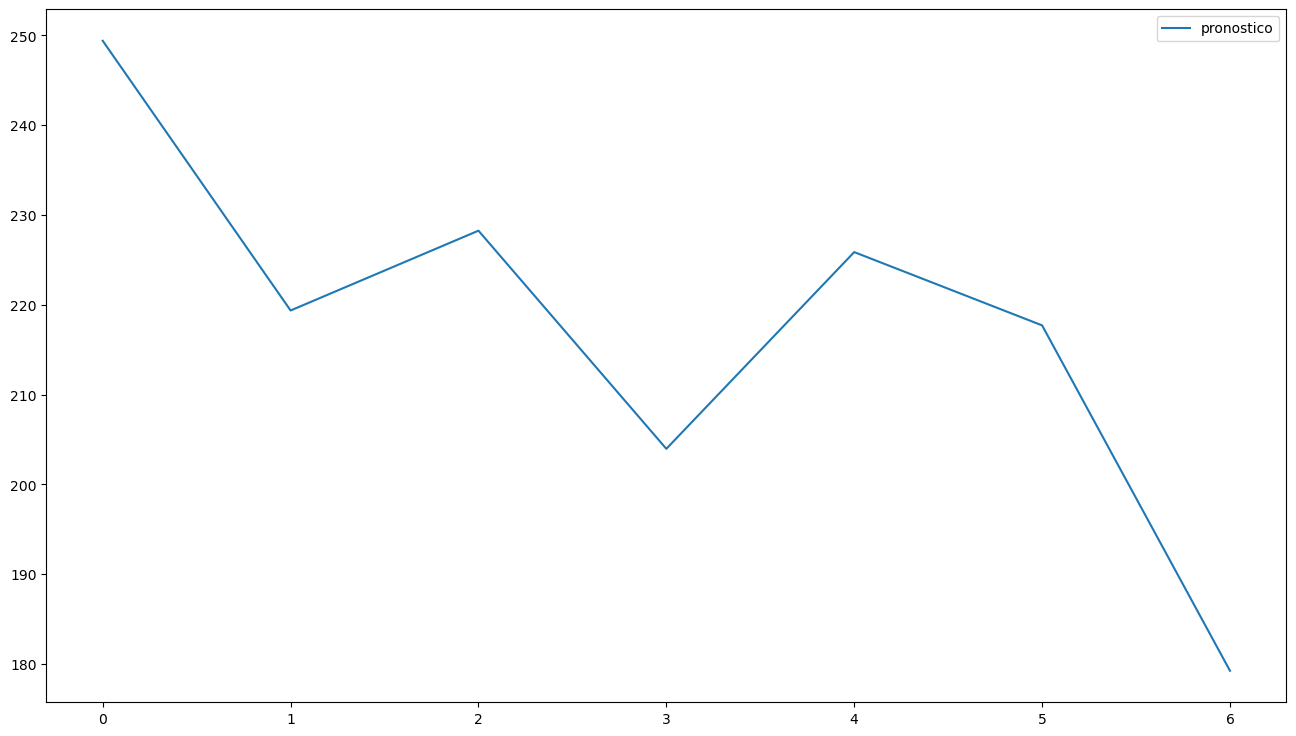

In [25]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()
prediccion1SemanaDiciembre.to_csv('pronostico.csv')

### 1.12. Agregamos el resultado en el dataset

In [26]:
i = 0
for fila in prediccion1SemanaDiciembre.pronostico:
    i+=1
    ultimosDias.loc['2018-12-0' + str(i) + '00:00:00'] = fila
    print(fila)
ultimosDias.tail(14)

249.39137658606566
219.36164392594196
228.24826154667724
203.95991662055067
225.86212961067548
217.70297775498727
179.2450415919358


C:\Users\pepel\AppData\Local\Temp\ipykernel_12544\2616865428.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultimosDias.loc['2018-12-0' + str(i) + '00:00:00'] = fila
C:\Users\pepel\AppData\Local\Temp\ipykernel_12544\2616865428.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultimosDias.loc['2018-12-0' + str(i) + '00:00:00'] = fila
C:\Users\pepel\AppData\Local\Temp\ipykernel_12544\2616865428.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

,unidades
fecha,
2018-11-24 00:00:00,189.000000
2018-11-25 00:00:00,76.000000
2018-11-26 00:00:00,276.000000
2018-11-27 00:00:00,220.000000
2018-11-28 00:00:00,183.000000
2018-11-29 00:00:00,251.000000
2018-11-30 00:00:00,189.000000
2018-12-0100:00:00,249.391377
2018-12-0200:00:00,219.361644
